In [1]:
import pandas as pd
df = pd.read_csv('New Data.csv') # Dataset is now stored in a Pandas Dataframe

print(df.head())

   Id                                           Judgment  Judgment Status
0   1  appeal judgment decree bombay high court stone...                1
1   2  application article 32 1 constitution enforcem...                2
2   3  appeal judgment high court hyderabad article 3...                0
3   4  appeal article 3744 constitution judgment decr...                0
4   5  petitions art 136 constitution praying special...                3


In [2]:
sentences = df[['Judgment','Judgment Status']]

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(sentences,  test_size=0.25, random_state=42)

In [3]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(df_train['Judgment Status'])
y_test = to_categorical(df_test['Judgment Status'])

In [4]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification

# load model and tokenizer and define length of the text sequence
Roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', num_classes=4)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=df_train.Judgment.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=df_test.Judgment.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_masak = True,
    verbose = True)

In [6]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model

In [8]:
max_len = 100

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = Roberta(input_ids, attention_mask = input_mask)[0]
out = Dense(128, activation='relu')(embeddings)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'sigmoid')(out)

Robertamodel = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
Robertamodel.layers[2].trainable = True

In [9]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy')

# Compile the model
Robertamodel.compile(
    optimizer = optimizer,
    loss=loss, 
    metrics = metric)

In [10]:
gxtrain_history = Robertamodel.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
    epochs=20,
    batch_size=64
)

Epoch 1/10


C:\Users\saray\anaconda3\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 95s 22s/step - loss: 1.3862 - balanced_accuracy: 0.2625 - val_loss: 1.3811 - val_balanced_accuracy: 0.3000
Epoch 2/10
4/4 [==============================] - 85s 21s/step - loss: 1.3801 - balanced_accuracy: 0.2708 - val_loss: 1.3626 - val_balanced_accuracy: 0.3000
Epoch 3/10
4/4 [==============================] - 87s 22s/step - loss: 1.3706 - balanced_accuracy: 0.2583 - val_loss: 1.3524 - val_balanced_accuracy: 0.3000
Epoch 4/10
4/4 [==============================] - 88s 22s/step - loss: 1.3643 - balanced_accuracy: 0.2583 - val_loss: 1.3290 - val_balanced_accuracy: 0.3000
Epoch 5/10
4/4 [==============================] - 87s 22s/step - loss: 1.3268 - balanced_accuracy: 0.2708 - val_loss: 1.3056 - val_balanced_accuracy: 0.3000
Epoch 6/10
4/4 [==============================] - 86s 22s/step - loss: 1.3226 - balanced_accuracy: 0.2708 - val_loss: 1.2960 - val_balanced_accuracy: 0.3000
Epoch 7/10
4/4 [==============================] - 89s 23s/step - loss

In [13]:
predicted_raw = Robertamodel.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

3/3 [==============================] - 9s 2s/step


array([0.64503753, 0.52731156, 0.26059517, 0.35708576], dtype=float32)

In [14]:
import numpy as np

y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = df_test['Judgment Status']

In [15]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_true, y_predicted))

print(accuracy_score(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.38      0.92      0.54        24
           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00        11
           3       0.55      0.75      0.63        16

    accuracy                           0.42        80
   macro avg       0.23      0.42      0.29        80
weighted avg       0.22      0.42      0.29        80

0.425


C:\Users\saray\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saray\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saray\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
x_train ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']}

loss, accuracy = Robertamodel.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.4417


In [17]:
x_test = {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}

loss, accuracy = Robertamodel.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.4250


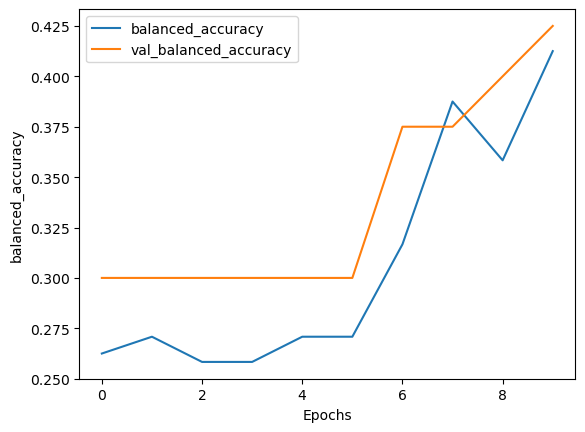

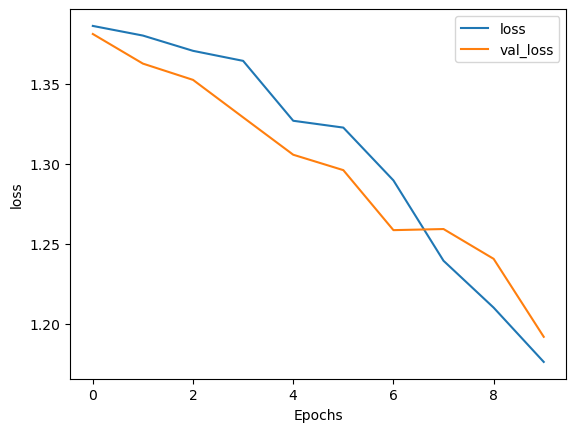

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(gxtrain_history, "balanced_accuracy")
plot_graphs(gxtrain_history, "loss")